Chapter 7 - Metropolis algorithm

In [1]:
import numpy as N
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta,stats 
from __future__ import division

In [2]:
%matplotlib inline

In [22]:
def Likelihood(theta,data):
    
    z = N.sum(data)
    n = len(data)
    if N.size(theta) == 1:
        pDataGivenTheta = 0
        if theta < 1 and theta > 0:
            pDataGivenTheta = theta**z * (1-theta)**(n-z)
    else:
        pDataGivenTheta = theta**z*(1-theta)**(n-z)
        # theta passed to this function are random and could inadvertently be beyond the [0,1] bounds
        pDataGivenTheta[(theta > 1) | (theta < 0)] = 0
    return pDataGivenTheta
    
def Prior(theta,form='uniform'):
    
    theta = N.array(theta)
    
    if form == 'uniform':
        if N.size(theta) == 1:
            prior = 0
            if theta < 1 and theta > 0:
                prior = 1
        else:
            prior = N.ones(len(theta)) # uniform density over [0,1]
            # in case the some of the thetas (generated randomly) passed are out of [0,1] bounds
            prior[(prior > 1) | (prior < 0)] = 0
    elif form == 'bimodal':
        
        prior = beta.pdf(N.minimum(2*theta,2*(1-theta)),2,2) # equiv. to R's dbeta func.
        # in case the some of the thetas (generated randomly) passed are out of [0,1] bounds
        prior[(prior > 1) | (prior < 0)] = 0
    
    elif form == '7.3':
        
        prior = (N.cos(4 * N.pi * theta) + 1) ** 2
    
    return prior

def TargetRelProb(theta,data,form='uniform'):
    
    # calculates the un-normalized posterior distribution
    targRelProb = Likelihood(theta,data) * Prior(theta,form)
    return targRelProb

In [23]:
"""HPD.py
This code was taken form the PyMC library https://github.com/pymc-devs/pymc
"""

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(N.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = N.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = N.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = N.shape(tx)
        # Container list for intervals
        intervals = N.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = N.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return N.array(intervals)
    else:
        # Sort univariate node
        sx = N.sort(x)
        return N.array(calc_min_interval(sx, alpha))

In [28]:
"""plot_post.py"""

def plot_post(param_sample_vec, cred_mass=0.95, comp_val=False,
              ROPE=False, ylab='', xlab='parameter', fontsize=14, labelsize=14,
              title='', framealpha=1, facecolor='skyblue', edgecolor='white',
              show_mode=True, bins=50):
    
    #compute HDI
    HDI = hpd(param_sample_vec, 1-cred_mass)

    post_summary = {'mean':0,'median':0,'mode':0, 'hdi_mass':0,'hdi_low':0,
                   'hdi_high':0, 'comp_val':0, 'pc_gt_comp_val':0, 'ROPE_low':0,
                   'ROPE_high':0, 'pc_in_ROPE':0}
    post_summary['mean'] = N.mean(param_sample_vec)
    post_summary['median'] = N.median(param_sample_vec)
    post_summary['mode'] = stats.mode(param_sample_vec)[0]
    post_summary['hdi_mass'] = cred_mass
    post_summary['hdi_low'] = HDI[0]
    post_summary['hdi_high'] = HDI[1]

    # Plot histogram.
    n, bins, patches = plt.hist(param_sample_vec, normed=True, bins=bins,
                                edgecolor=edgecolor, facecolor=facecolor)
    plt.xlabel(xlab, fontsize=fontsize)
    plt.ylabel(ylab, fontsize=fontsize)
    plt.title(title, fontsize=fontsize)

    cv_ht = 0.75*N.max(n)
    cen_tend_ht = 0.9 * cv_ht
    ROPE_text_ht = 0.55 * cv_ht
#    # Display mean or mode:
    if show_mode:
        plt.plot(0, label='mode = %.2f' % post_summary['mode'], alpha=0)
    else:
        plt.plot(0, label='mean = %.2f' % post_summary['mean'], alpha=0)
    # Display the comparison value.

    if comp_val is not False:
        pc_gt_comp_val = 100 * N.sum(param_sample_vec > comp_val)/len(param_sample_vec)
        pc_lt_comp_val = 100 - pc_gt_comp_val
        plt.plot([comp_val, comp_val], [0, cv_ht], color='darkgreen',
                 linestyle='--', linewidth=2,
                 label='%.1f%% <%.1f < %.1f%%'
                 % (pc_lt_comp_val, comp_val, pc_gt_comp_val))
        post_summary['comp_val'] = comp_val
        post_summary['pc_gt_comp_val'] = pc_gt_comp_val
#    # Display the ROPE.
    if ROPE is not False:
        rope_col = 'darkred'
        pc_in_ROPE = round(N.sum((param_sample_vec > ROPE[0]) & (param_sample_vec < ROPE[1]))/len(param_sample_vec)*100)
        plt.plot([ROPE[0], ROPE[0]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4,
                label='%.1f%% in ROPE' % pc_in_ROPE)
        plt.plot([ROPE[1], ROPE[1]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4)
        post_summary['ROPE_low'] = ROPE[0] 
        post_summary['ROPE_high'] = ROPE[1] 
        post_summary['pc_in_ROPE'] = pc_in_ROPE
#    # Display the HDI.
    plt.plot(HDI, [0, 0], linewidth=6, color='k', label='HDI %.1f%% %.3f-%.3f' % (cred_mass*100, HDI[0], HDI[1]))
    plt.legend(loc='upper left', fontsize=labelsize, framealpha=framealpha)
    return post_summary

In [15]:
myData = N.repeat([1,0],[7,3])

In [48]:
def Main(myData,pjMean = 0,pjSc=0.1,priorForm='uniform'):
    # pjMean and pjSc are the statistic parameters for the distribution from which the proposed jump 
    # is drawn.
 
    # Specify the length of the trajectory, i.e. the number of jumps to try:
    trajLength = 11112 # arbitrary large number
    # Initialize the vector that will store the results:
    trajectory = N.zeros(trajLength)
    # Specify where to start the trajectory:
    trajectory[0] = 0.5 # arbitrary value
    # Specify the burn-in period:
    burnIn = N.ceil(0.1 * trajLength) # arbitrary number, less than trajLength
    # Initialize accepted/rejected counters, just to monitor performance
    nAccepted = 0
    nRejected = 0
    # Specify seed to reproduce same random walk
    N.random.seed(47405)

    # Now generate the random walk. The 't' index is time or trial in the walk

    for t in range(trajLength-1):
        currPos=trajectory[t]
        # Use the proposal distribution to generate a proposed jump.
        # The shape/variance of the proposal distribution can be changed
        # to whatever you think is appropriate for the target distribution.
        proposedJump=N.random.normal(loc=pjMean,scale=pjSc,size=1)
        # Generate a random uniform value from the interval [0,1]
        acceptCrit = N.random.uniform(size=1)
        # Compute the probability of accepting the proposed jump:
        probAccept = N.minimum(1,TargetRelProb(currPos + 
                                               proposedJump,myData,form=priorForm) / 
                               TargetRelProb(currPos,myData,form=priorForm))
        if acceptCrit < probAccept:
            # accept the proposed jump
            trajectory[t+1] = currPos + proposedJump
            #increment the acceptance counter (just to monitor performance)
            if t>burnIn:
                nAccepted += 1
        else:
            # reject the proposed jump, stay at current position
            trajectory[t+1] = currPos
            # increment the rejection counter
            if t>burnIn:
                nRejected += 1

    #Extract the post burn-in part of the trajectory
    acceptedTraj = trajectory[burnIn + 1:]

    # END OF METROPOLIS ALGORITHM
    #----------------------------------------------------------------------

    # Display the posterior

    # Display rejected/accepted ratio in the plot
    mean_traj = N.mean(acceptedTraj)
    std_traj = N.std(acceptedTraj)

    plt.figure(figsize=(16,12)) # Brian added

    plt.subplot(411)
    plt.plot(0, label=r'$N_{pro}=%s$  |$\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(acceptedTraj), (nAccepted/len(acceptedTraj))), alpha=0)

    # Evidence for model, p(D).

    # Compute a,b parameters for beta distribution that has the same mean
    # and stdev as the sample from the posterior. This is a useful choice
    # when the likelihood function is Bernoulli.
    a = 10#mean_traj * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)
    b = 10#(1 - mean_traj) * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)

    # For every theta value in the posterior sample, compute 
    # dbeta(theta,a,b) / likelihood(theta)*prior(theta)
    # This computation assumes that likelihood and prior are proper densities,
    # i.e., not just relative probabilities. This computation also assumes that
    # the likelihood and prior functions were defined to accept a vector argument,
    # not just a single-component scalar argument.
    wtd_evid = beta.pdf(acceptedTraj, a, b) / (Likelihood(acceptedTraj, myData) * Prior(acceptedTraj,form=priorForm))
    p_data = 1 / N.mean(wtd_evid)


    # Display p(D) in the graph
    plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)

    # Display the posterior.
    ROPE = N.array([0.76, 0.8])
    mcmc_info = plot_post(acceptedTraj,title='SD = ' + str(pjSc), xlab='theta', show_mode=False, comp_val=0.9, ROPE=ROPE)
    plt.subplot(412)
    plt.plot(acceptedTraj,N.arange(1,len(acceptedTraj)+1),'ko-')
    plt.xlim(0,1)
    
    plt.subplot(413)
    plt.plot(wtd_evid)
    
    plt.subplot(414)
    plt.plot(acceptedTraj,wtd_evid,'r.')

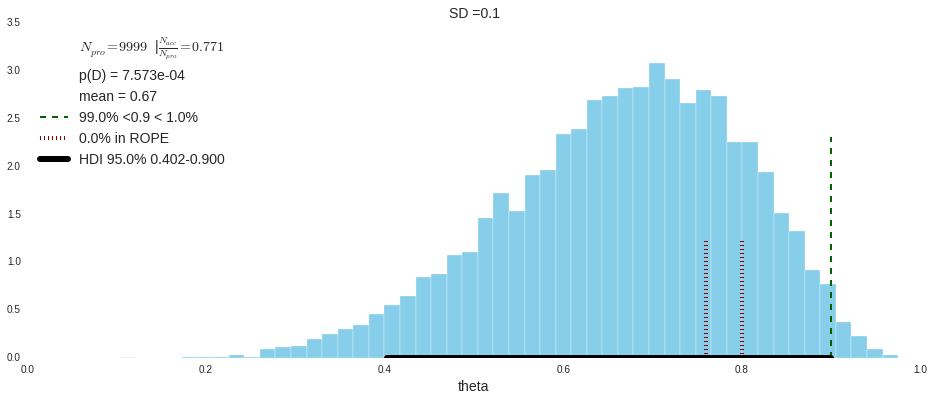

In [27]:
#Ex7.1-A), proposal distribution sd=0.1
Main()

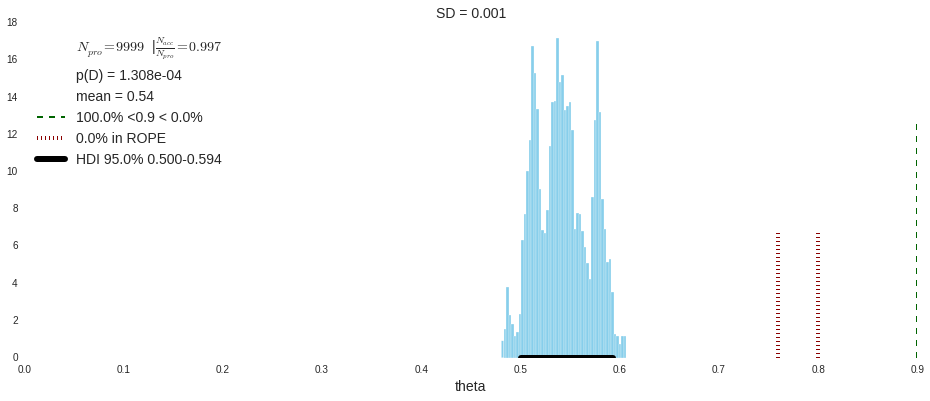

In [29]:
#Ex7.1-B) proposal distribution sd=0.001
Main(pjSc=0.001)

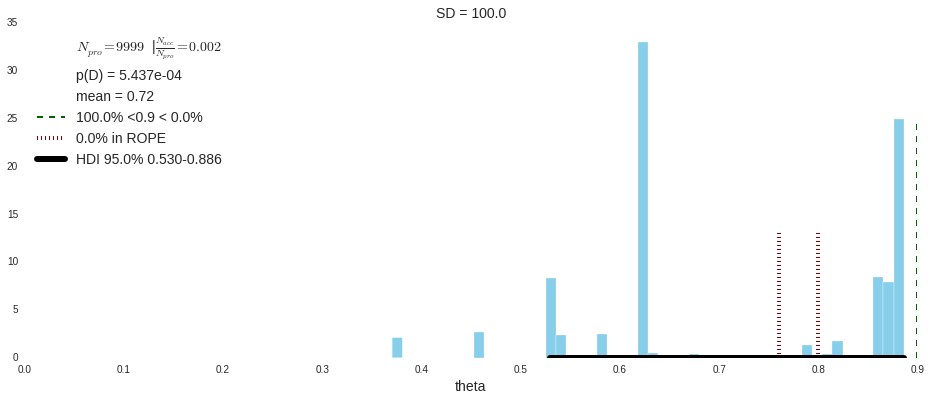

In [30]:
#Ex7.1-C) proposal distribution sd=100.0
Main(pjSc=100.0)

7.1-D) 
    * sd = 0.1 gave the most accurate representation of the posterior
    * sd = 0.001 had the fewest rejected proposals
    * sd = 100 had the most rejects

       

In [32]:
def Main2(pjMean = 0,pjSc=0.1):
    
 
    # Specify the length of the trajectory, i.e. the number of jumps to try:
    trajLength = 100 # arbitrary large number
    # Initialize the vector that will store the results:
    trajectory = N.zeros(trajLength)
    # Specify where to start the trajectory:
    trajectory[0] = 0.001 # arbitrary value
    # Specify the burn-in period:
    burnIn = N.ceil(0.01 * trajLength) # arbitrary number, less than trajLength
    # Initialize accepted/rejected counters, just to monitor performance
    nAccepted = 0
    nRejected = 0
    # Specify seed to reproduce same random walk
    N.random.seed(47405)

    # Now generate the random walk. The 't' index is time or trial in the walk

    for t in range(trajLength-1):
        currPos=trajectory[t]
        # Use the proposal distribution to generate a proposed jump.
        # The shape/variance of the proposal distribution can be changed
        # to whatever you think is appropriate for the target distribution.
        proposedJump=N.random.normal(loc=pjMean,scale=pjSc,size=1)
        # Generate a random uniform value from the interval [0,1]
        acceptCrit = N.random.uniform(size=1)
        # Compute the probability of accepting the proposed jump:
        probAccept = N.minimum(1,TargetRelProb(currPos + proposedJump,myData)/TargetRelProb(currPos,myData))
        if acceptCrit < probAccept:
            # accept the proposed jump
            trajectory[t+1] = currPos + proposedJump
            #increment the acceptance counter (just to monitor performance)
            if t>burnIn:
                nAccepted += 1
        else:
            # reject the proposed jump, stay at current position
            trajectory[t+1] = currPos
            # increment the rejection counter
            if t>burnIn:
                nRejected += 1

    #Extract the post burn-in part of the trajectory
    acceptedTraj = trajectory[burnIn + 1:]
    
    # END OF METROPOLIS ALGORITHM
    #----------------------------------------------------------------------

    # Display the posterior

    # Display rejected/accepted ratio in the plot
    mean_traj = N.mean(acceptedTraj)
    std_traj = N.std(acceptedTraj)

    plt.figure(figsize=(16,12)) # Brian added
    plt.subplot(211)
    plt.plot(0, label=r'$N_{pro}=%s$  |$\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(acceptedTraj), (nAccepted/len(acceptedTraj))), alpha=0)

    # Evidence for model, p(D).

    # Compute a,b parameters for beta distribution that has the same mean
    # and stdev as the sample from the posterior. This is a useful choice
    # when the likelihood function is Bernoulli.
    a = mean_traj * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)
    b = (1 - mean_traj) * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)

    # For every theta value in the posterior sample, compute 
    # dbeta(theta,a,b) / likelihood(theta)*prior(theta)
    # This computation assumes that likelihood and prior are proper densities,
    # i.e., not just relative probabilities. This computation also assumes that
    # the likelihood and prior functions were defined to accept a vector argument,
    # not just a single-component scalar argument.
    wtd_evid = beta.pdf(acceptedTraj, a, b) / (Likelihood(acceptedTraj, myData) * Prior(acceptedTraj))
    p_data = 1 / N.mean(wtd_evid)


    # Display p(D) in the graph
    
    plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)

    # Display the posterior.
    ROPE = N.array([0.76, 0.8])
    mcmc_info = plot_post(acceptedTraj,title='SD = ' + str(pjSc), xlab='theta', show_mode=True, comp_val=0.9, ROPE=ROPE)
    plt.subplot(212)
    plt.plot(acceptedTraj,N.arange(1,len(acceptedTraj)+1),'ko-')
    plt.xlim(0,1)

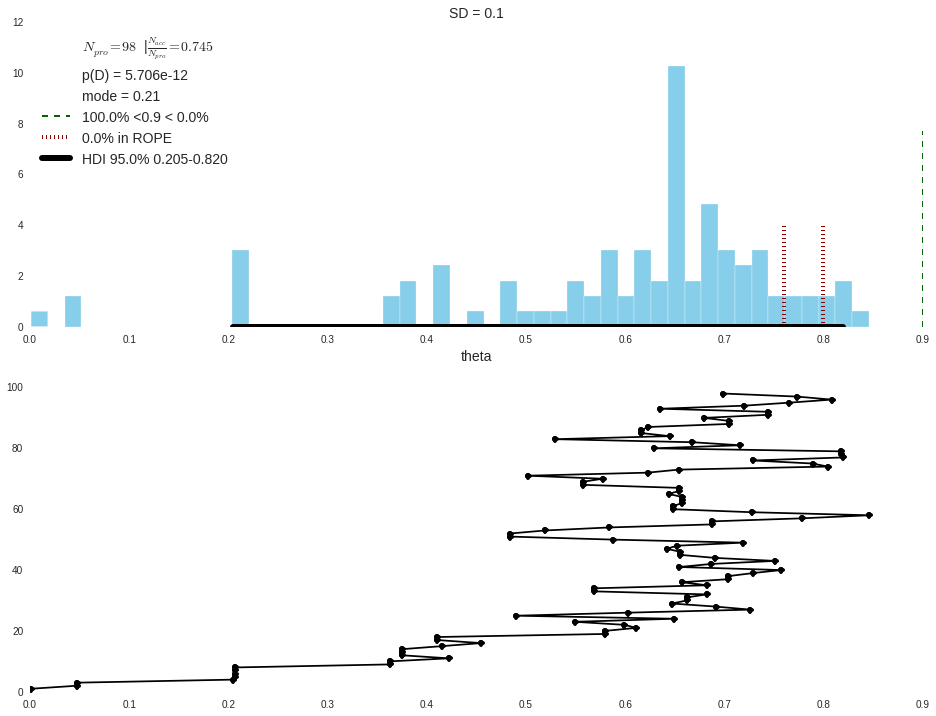

In [51]:
Main2()

7.2 - A) 
       - 100 jumps are proposed,  
       - 1 step burnin, 
       - $\theta$ starts at 0.001.
     -B) the histogram has many points for $\theta$ < 0.5 because sd =0.1 is fairly small, i.e. proposed jumps are small.
     -C) there are so few points (relatively) for $\theta$ < 0.5 because few of them are accepted.

In [52]:
# HERE IS THE PYMC VERSION OF THE ABOVE
import pymc3 as pm
y = np.repeat([1,0],[7,3])
with pm.Model() as model:
    #define the prior
    theta = pm.Beta('theta',1,1)
    # define the likelihood 
    y = pm.Bernoulli('y',p=theta,observed=y)
    
    # Generate a MCMC chain
    trace = pm.sample(5000,pm.Metropolis(),progressbar=False)
#create an array with the posterior sample
theta_sample = trace['theta']
print "theta_sample", theta_sample
plt.figure(figsize=(16,6)) # Brian added

plt.subplot(1, 2, 1)
plt.plot(theta_sample[:500], np.arange(500), marker='o')
plt.xlim(0, 1)
plt.xlabel(r'$\theta$')
plt.ylabel('Position in Chain')

plt.subplot(1, 2, 2)
mcmc_info = plot_post(theta_sample, xlab=r'$\theta', show_mode=False)

Couldn't import dot_parser, loading of dot files will not be possible.


In [20]:
"""HPD.py
This code was taken form the PyMC library https://github.com/pymc-devs/pymc
"""

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(N.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = N.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = N.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = N.shape(tx)
        # Container list for intervals
        intervals = N.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = N.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return N.array(intervals)
    else:
        # Sort univariate node
        sx = N.sort(x)
        return N.array(calc_min_interval(sx, alpha))

def BernGrid(theta , pTheta , data , cred = 0.95, **kwargs):
    """
    Bayesian updating for Bernoulli liklihood and prior specified on a grid.
    
    Input arguments:
        theta: vector, b/w 0 and 1
        pTheta: vecor of corresp. probability masses
        data: vector of 1's and 0's, where 1 corresponds to a and 0 to b.
        cred: prob mass of credible interval, defaults to 0.95
        nToPlot: number of grid points to plot, defaults to all specified in theta
    
    Output:
        pThetaGivenData: vector, posterior probabil. masses over theta.
        3-panel graph of prior, likelihood, and posterior w/ cred. interval.
        
    Example of use:
        Create vector of theta values
            
            binwidth = 1/1000
            thetagrid = N.arange(binwidth/2 1+binwidth/2, binwidth)
            
        Specify probability mass at each theta value
            
            relprob =  -> define relative probability at each theta value
            prior = relprob / sum(relprob) -> prob mass at each theta value
        
        Specify the data vector
            
            datavec = 3 * [1] + 2 * [0]
        
        Call BernGrid: 
            
            posterior = BernGrid(theta = thetagrid,pTheta = prior,data = datavec)
    
    """
    if 'nToPlot' in kwargs.keys():
        nToPlot = kwargs['nToPlot']
    else:
        nToPlot = len(theta)
        
    z = sum(data) # number of heads (1s)
    ndata = len(data)
    
    # compute the likelihood of the data for each value of theta
    pDataGivenTheta = theta ** z * (1 - theta) ** (ndata - z)
    
    # compute the evidence and the posterior
    pData = sum(pDataGivenTheta * pTheta)
    pThetaGivenData = pTheta * pDataGivenTheta / pData
    
    # determine the limits of the highest density interval
    x = N.random.choice(theta,size=5000,replace=True,p=pThetaGivenData)
    intervals = hpd(x,alpha=1-cred)
    
# Plot the results:
    plt.figure(figsize = (12,10))
    plt.subplots_adjust(hspace=0.7)
    
    # Plot the prior
    locx = 0.05
    meanTheta = sum(theta * pTheta) # mean of prior
    plt.subplot(3,1,1)
    plt.plot(theta,pTheta)
    plt.xlim(0,1)
    plt.ylim(0,N.max(pTheta) * 1.2)
    plt.xlabel(r'$\theta$',fontsize=16)
    plt.ylabel(r'$P(\theta)$',fontsize=16)
    plt.title('Prior')
    plt.text(locx,N.max(pTheta)*.75,r'$\theta_{mean}$=%5.2f' % meanTheta,fontsize=16)
    
    #Plot the likelihood
    plt.subplot(3,1,2)
    plt.plot(theta,pDataGivenTheta)
    plt.xlim(0,1)
    plt.ylim(0,N.max(pDataGivenTheta)*1.2)
    plt.xlabel(r'$\theta$',fontsize=16)
    plt.ylabel(r'$P(D|\theta)$',fontsize=16)
    plt.title('Likelihood')
    plt.text(locx,N.max(pDataGivenTheta) / 2,'data: z=%s, N=%s' %(z,ndata),fontsize=16)
    
    #Plot the posterior
    meanThetaGivenData = sum(theta*pThetaGivenData)
    plt.subplot(3,1,3)
    plt.plot(theta,pThetaGivenData)
    plt.xlim(0,1)
    plt.ylim(0,N.max(pThetaGivenData) * 1.2)
    plt.xlabel(r'$\theta$',fontsize=16)
    plt.ylabel(r'$P(\theta|D)$',fontsize=16)
    plt.title('Posterior')
    locy = N.linspace(0,N.max(pThetaGivenData),5)
    plt.text(locx,locy[1],r'$\theta_{mean}$=%5.2f' % meanThetaGivenData,fontsize=16)
    plt.text(locx,locy[2],'P(D) = %g' % pData,fontsize = 16)
    
    #plot HDIs
    plt.text(locx,locy[3],
            'Intervals=%s' % ', '.join('%.3f' % x for x in intervals),fontsize=16)
    for i in range(0,len(intervals),2):
        plt.fill_between(theta,0,pThetaGivenData,
                         where=N.logical_and(theta > intervals[i],
                                             theta < intervals[i+1]),
                        color='blue',alpha=0.3)
    plt.show()
    return pThetaGivenData   

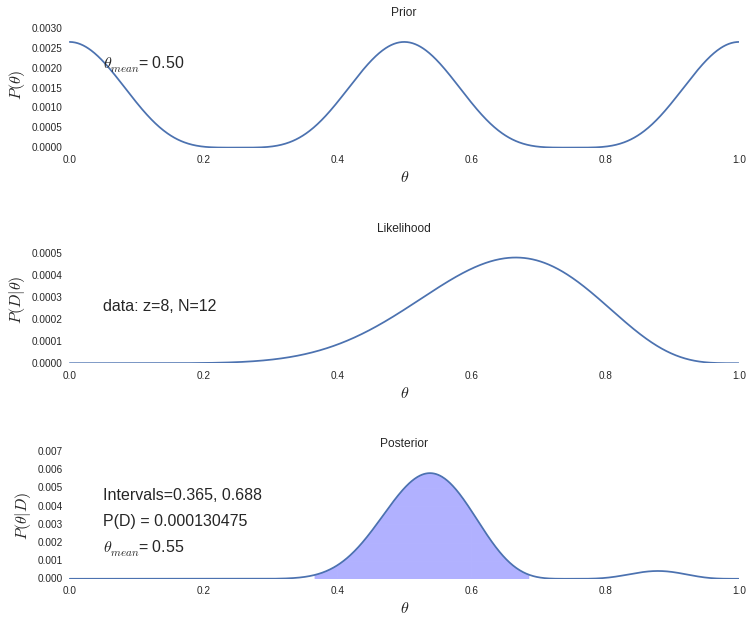

In [21]:
#7.3 -A solved on paper
#    -B syntax below is taken from example in BernGrid comments.
binwidth = 1/1000
thetagrid = N.arange(binwidth/2, 1+binwidth/2, binwidth)
#relprob =  -> define relative probability at each theta value
relprob = (N.cos(4*N.pi * thetagrid)+1) ** 2
prior = relprob / sum(relprob) #-> prob mass at each theta value
        
#Specify the data vector
datavec = 8 * [1] + 4 * [0]
        
#Call BernGrid: 
posterior = BernGrid(theta = thetagrid,pTheta = prior,data = datavec)

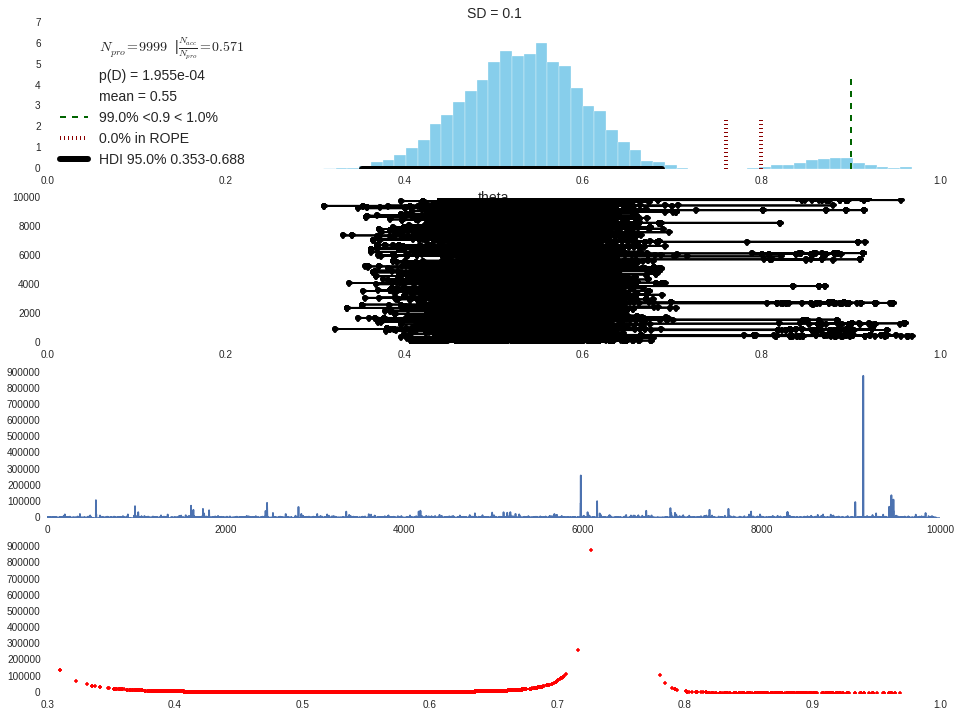

In [44]:
#7-3-C
datvec=N.repeat([1,0],[8,4])
Main(datvec,pjMean=0,pjSc=0.1,priorForm='7.3')

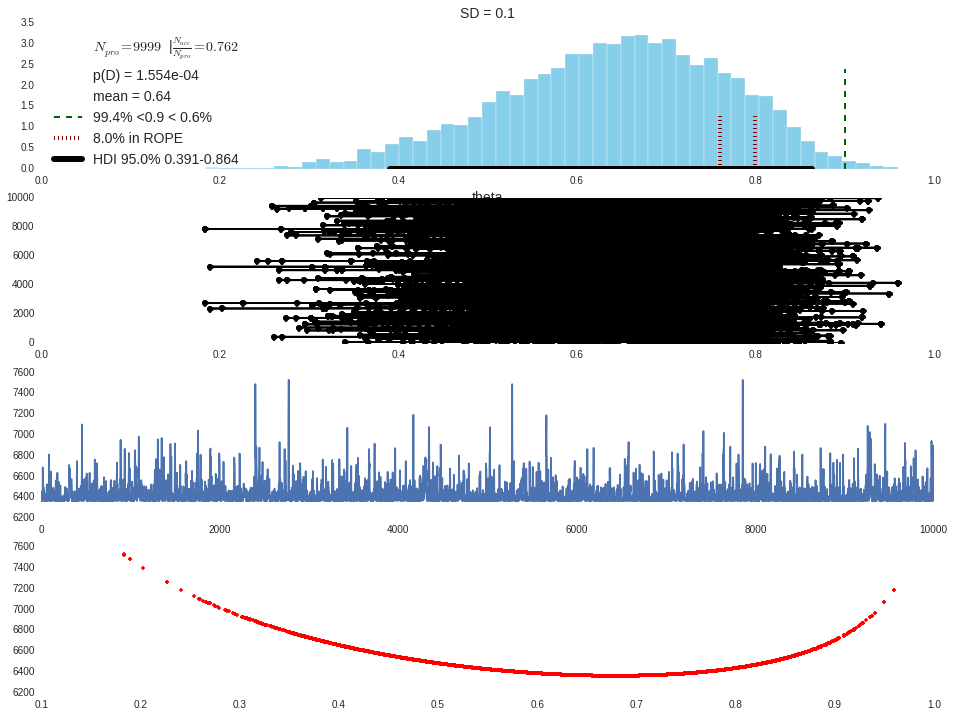

In [45]:
#7-4-A wtdEvid is weighted evidence
datvec=N.repeat([1,0],[8,4])
Main(datvec,pjMean=0,pjSc=0.1)

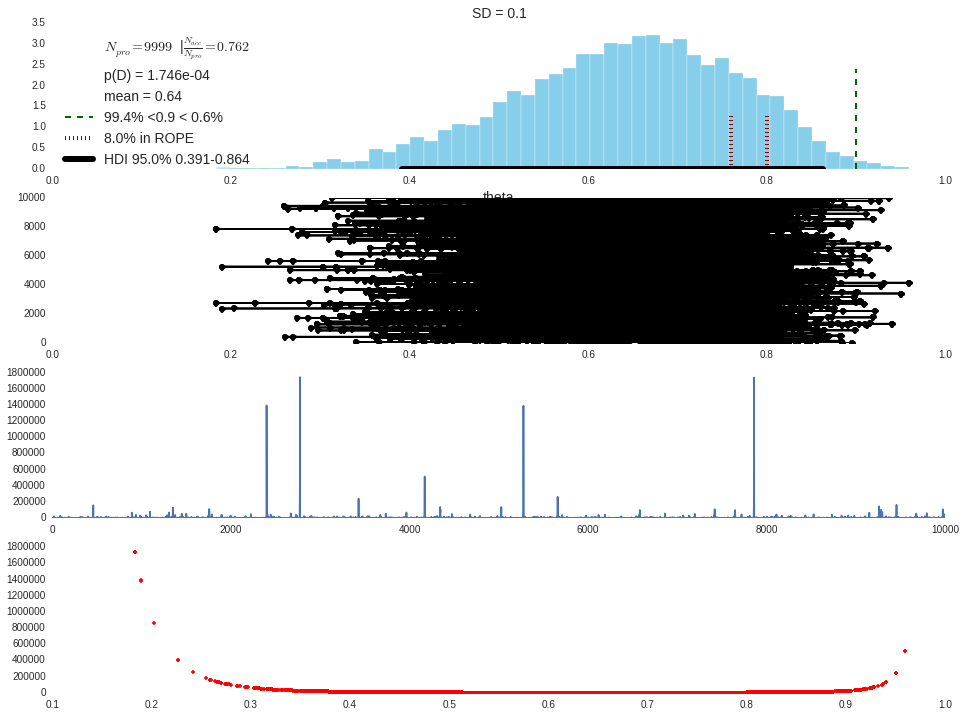

In [47]:
#7-4-B # here I've set a=b=1 in Main()
datvec=N.repeat([1,0],[8,4])
Main(datvec,pjMean=0,pjSc=0.1)

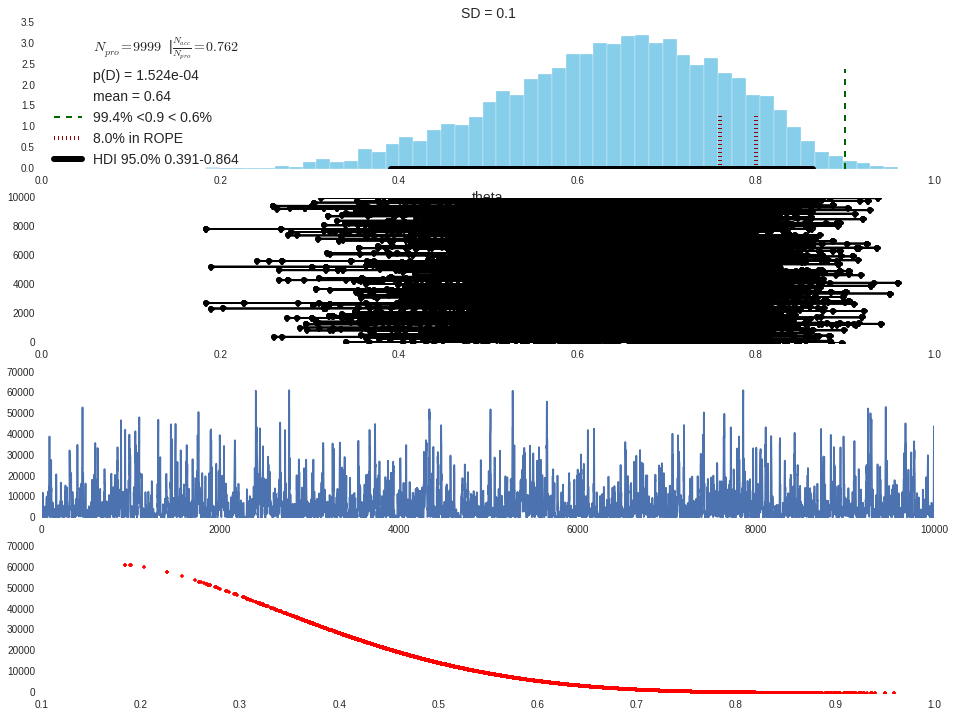

In [49]:
#7-4-B # here I've set a=b=10 in Main()
datvec=N.repeat([1,0],[8,4])
Main(datvec,pjMean=0,pjSc=0.1)

In [50]:
from pymc3 import Model,Bernoulli

In [51]:
from pymc3 import Normal

In [52]:
def 

TypeError: No model on context stack, which is needed to use the Normal('x', 0,1) syntax. Add a 'with model:' block